Developing models using TensorFlow is easy and fun, but real understanding can be achieved only via reading and implementing the algorithms on your own. This time we will skip TensorFlow entirely and build a Neural Network (shallow one) from scratch, using only pure Python and NumPy. The real challenge is to implement the core algorithm that is used to train (Deep) Neural Networks - Backpropagation. Shall we dance?

# Setup

Let's begin by preparing our environment and seeding the random number generator properly:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from preprocessing import *
from math_utils import *
from plotting import *

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

We are importing 3 custom modules that contain some helper functions that we are going to use along the way!

# Background

## Sigmoid (and it's derivative)

The sigmoid function is used quite commonly in the realm of deep learning, at least it was until recently. It has distinct **S** shape and it is a differentiable real function for any real input value. Additionally, it has a positive derivative at each point. More importantly, we will use it as an activation function for the hidden layer of our model. Here's how it is defined:

$$\sigma (x) = \frac{1}{1+e^{-x}}$$

It's first derivative (which we will use during the backpropagation step of our training algorithm) has the following formula:

$$\frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x))$$

So, the derivative can be expressed using the original sigmoid function. Pretty cool, eh? Don't like formulas? Let's look at a picture:

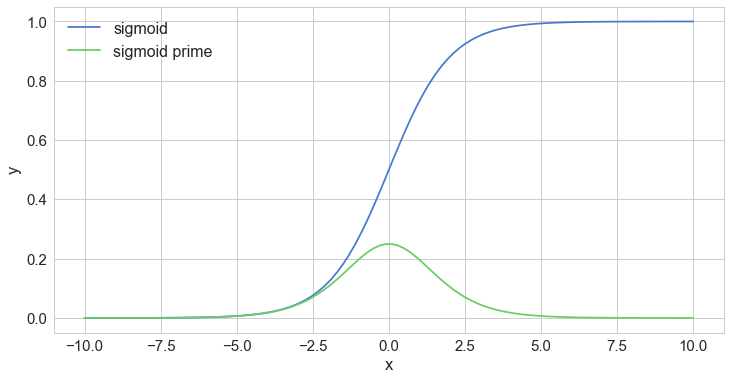

In [2]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

The derivative shows us the rate of change of a function. We can use it to determine the "slope" of that function. The highest rate of change for the sigmoid function is when $x=0$, as it is evident from the derivative graph (in green).

If your Calculus feels a bit rusty take a look at [this worked example](http://kawahara.ca/how-to-compute-the-derivative-of-a-sigmoid-function-fully-worked-example/). That should get you there.

## Softmax

The softmax function can be easily differentiated, it is pure (output depends only on input) and the elements of the resulting vector sum to 1. Here it is:

$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{K}^{k=1}e^{z_k}} \text{for}\,j = 1,...,k$$

In probability theory, the output of the softmax function is sometimes used as a representation of a categorical distribution. Let's see an example result:

In [3]:
softmax(np.array([[2, 4, 6, 8]]))

array([[ 0.00214401,  0.0158422 ,  0.11705891,  0.86495488]])

The output has most of its weight corresponding to the input 8. The softmax function highlights the largest value(s) and suppresses the smaller ones.

## NumPy

We will use NumPy primarily for its Linear Algebra magic when working with matrices. Let's define 2 matrices:

In [4]:
m1 = np.array([[1, 2, 3], [2, 3, 4]])
m2 = np.array([[3, 2, 1], [4, 3, 2]])

m1

array([[1, 2, 3],
       [2, 3, 4]])

See the dimensions of the first matrix (rows, columns):

In [5]:
m1.shape

(2, 3)

Transpose the second matrix:

In [6]:
m2.T

array([[3, 4],
       [2, 3],
       [1, 2]])

And see its dimensions:

In [7]:
m2.T.shape

(3, 2)

Find the dot product of the matrices:

In [8]:
m1.dot(m2.T)

array([[10, 16],
       [16, 25]])

Finally, matrix multiplication:

In [9]:
np.multiply(m1, m2)

array([[3, 4, 3],
       [8, 9, 8]])

NumPy is pretty useful. You just have to be careful with the dimensions!

## Backpropagation

Backpropagation is the backbone of almost anything we do when using Neural Networks. The algorithm consists of 3 subtasks:

* Make a forward pass
* Calculate the error
* Make backward pass (backpropagation)

In the first step, backprop uses the data and the weights of the network to compute a prediction. Next, the error is computed based on the prediction and the provided labels. The final step propagates the error through the network, starting from the final layer. Thus, the weights get updated based on the error, little by little.

Let's build more intuition about what the algorithm is actually doing:

<iframe width="100%" height="480" src="https://www.youtube.com/embed/cCRnjHjBDFQ" frameborder="0" allowfullscreen></iframe>

We will try to create a Neural Network (NN) that can properly predict values from the *XOR* function. Here is its truth table:

| Input 1 	| Input 2 	| Output 	|
|---------	|---------	|--------	|
| 0       	| 0       	| 0      	|
| 0       	| 1       	| 1      	|
| 1       	| 0       	| 1      	|
| 1       	| 1       	| 0      	|

Here is a visual representation:

<img src="https://wantee.github.io/assets/images/posts/xor.png" width="60%">

Let start by defining some parameters:

In [10]:
epochs = 50000
input_size, hidden_size, output_size = 2, 3, 1
LR = .1 # learning rate

Our data looks like this:

In [11]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

Initialize the weights of our NN to random numbers (using proper size):

In [12]:
w_hidden = np.random.uniform(size=(input_size, hidden_size))
w_output = np.random.uniform(size=(hidden_size, output_size))

Finally, implementation of the Backprop algorithm:

In [13]:
for epoch in range(epochs):
 
    # Forward
    act_hidden = sigmoid(np.dot(X, w_hidden))
    output = np.dot(act_hidden, w_output)
    
    # Calculate error
    error = y - output
    
    if epoch % 5000 == 0:
        print(f'error sum {sum(error)}')

    # Backward
    dZ = error * LR
    w_output += act_hidden.T.dot(dZ)
    dH = dZ.dot(w_output.T) * sigmoid_prime(act_hidden)
    w_hidden += X.T.dot(dH)

error sum [-1.77496016]
error sum [ 0.00586565]
error sum [ 0.00525699]
error sum [ 0.0003625]
error sum [-0.00064657]
error sum [ 0.00189532]
error sum [  3.79101898e-08]
error sum [  7.47615376e-13]
error sum [  1.40960742e-14]
error sum [  1.49842526e-14]


That error seems to be decreasing! YaY! And the implementation is not that scary, isn't it? We just multiply the matrix containing our training data with the matrix of the weights of the hidden layer. Then, we apply the activation function (sigmoid) to the result and multiply that with the weight matrix of the output layer.

The error is computed by doing simple subtraction. During the backpropagation step, we adjust the weight matrices using the already computed error and use the derivative of the sigmoid function.

Let's try to predict using our trained model (doing just the forward step):

In [14]:
X_test = X[1] # [0, 1]

act_hidden = sigmoid(np.dot(X_test, w_hidden))
np.dot(act_hidden, w_output)

array([ 1.])

What is this sorcery? The prediction is correct! You can try some of the other input examples.

# Building our own Neural Network Classifier

The "hello world" dataset MNIST ("Modified National Institute of Standards and Technology"), released in 1999, contains images of handwritten digits. Our goal is to build a model that correctly identify digits from a dataset of tens of thousands of handwritten digits.

We will build our own "vanilla" Neural Network classifier that learns from raw pixels using only Python and NumPy. Let's start by reading the data:

## Reading and shuffling the images

In [15]:
IMAGES_PATH = 'train-images-idx3-ubyte'
LABELS_PATH = 'train-labels-idx1-ubyte'

N_FEATURES = 28 * 28
N_CLASSES = 10

In [16]:
X, y = read_mnist(IMAGES_PATH, LABELS_PATH)
X, y = shuffle_data(X, y, random_seed=RANDOM_SEED)
X_train, y_train = X[:500], y[:500]
X_test, y_test = X[500:], y[500:]

We reserve 500 training examples for evaluation of our model.

## Data exploration

Let's take a look at how some handwritten digits look like:

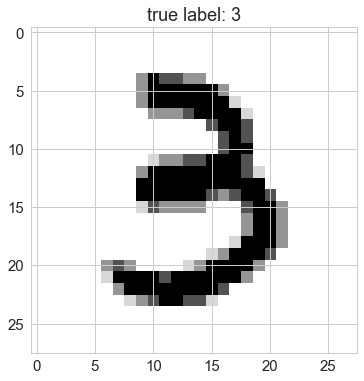

In [17]:
plot_digit(X, y, idx=1)

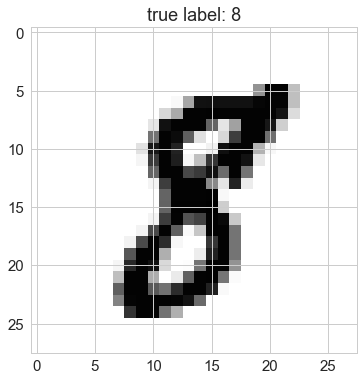

In [18]:
plot_digit(X, y, idx=2)

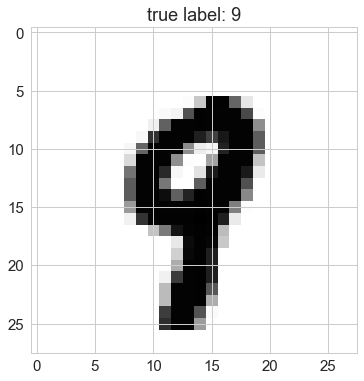

In [19]:
plot_digit(X, y, idx=3)

## Implementing the model

Let's define a class, called **NNClassifier** that does all the dirty work for us. We will implement a somewhat more sophisticated version of our training algorithm shown above along with some handy methods:

In [32]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_hidden_units * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden_units, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_classes * (self.n_hidden_units + 1))
        w2 = w2.reshape(self.n_classes, self.n_hidden_units + 1)
        return w1, w2

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        return X_new

    def _forward(self, X):
        net_input = self._add_bias_unit(X, how='column')
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)
        act_hidden = self._add_bias_unit(act_hidden, how='row')
        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        sigma3 = act_out - y
        net_hidden = self._add_bias_unit(net_hidden, how='row')
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2

    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)

    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1[:, 1:] += (self.w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (self.w2[:, 1:] * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grad1, grad2

    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return mle(net_out.T)
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
        for i in range(self.epochs):

            X_mb = np.array_split(X_data, self.n_batches)
            y_mb = np.array_split(y_data_enc, self.n_batches)
            
            epoch_errors = []

            for Xi, yi in zip(X_mb, y_mb):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

All the magic is hidden within the *_forward*, *_backward*, *_error* and *_backprop_step* methods. We measure the error using cross-entropy loss function. Additionally, L1 and L2 regularizations are used to drive our training into simpler models. One preprocessing step that our model is doing internally is the encoding of the labels as one-hot vectors via the helper function - *one_hot*.

Our NN has a neat interface, too! Use the *fit* method to train it, *predict* to predict the class of a digit and *score* to assess the overall performance of the model.

## Training

It's time to reap the benefits of our hard work. Let's train our NN for 300 epochs with 50 neurons in the hidden layer:

In [96]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train, y_train);

## Evaluation

First, let's have a look at the error change as the number of training epochs increase:

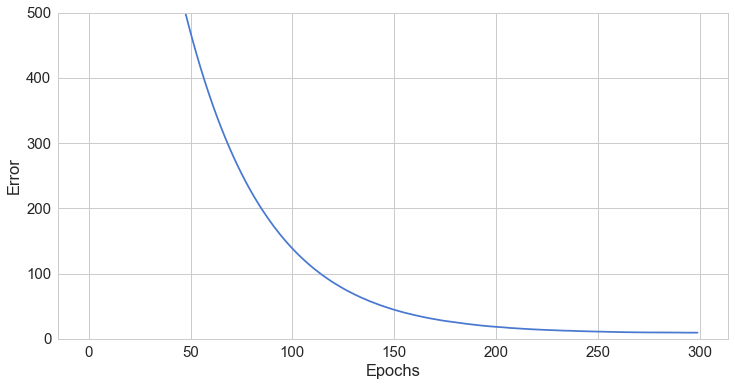

In [34]:
plot_error(nn)

Good, it look like it is converging to a low value. More importantly, let's check how good our model's predictions are on training and test sets:

In [23]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 91.80%
Test Accuracy: 81.65%


Our test accuracy is not that good, especially when compared to the results obtained [via other models](http://yann.lecun.com/exdb/mnist/). Let's check the probability distribution for a single example:

In [24]:
nn.predict_proba(X_test[1:2])

array([[ 0.09006643,  0.08982926,  0.09148965,  0.08801483,  0.08905539,
         0.09358783,  0.18462954,  0.08784268,  0.09758406,  0.08790033]])

You can "clearly" see that the most probable digit is 6.

### Correct prediction

Let's look at the image itself:

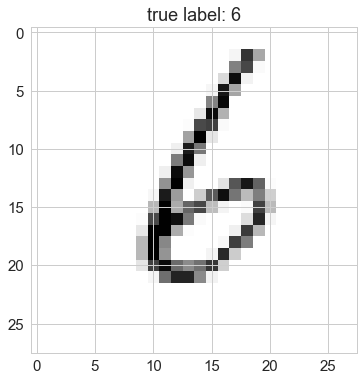

In [25]:
plot_digit(X_test, y_test, idx=1)

And the probability distribution:

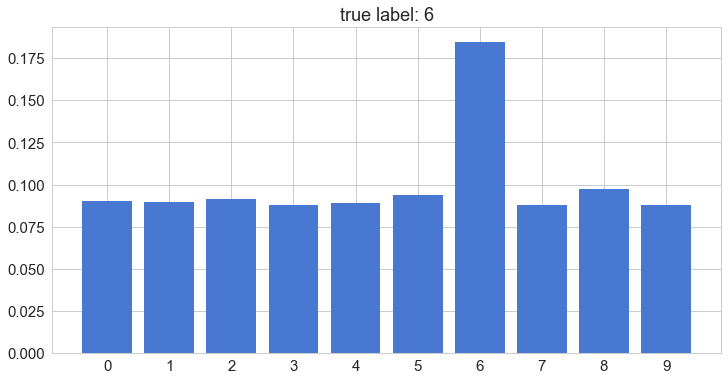

In [26]:
plot_digit_dist(X_test, y_test, idx=1, model=nn)

Our model looks quite sure about its prediction. Let's have a look at a wrong prediction:

### Wrong prediction

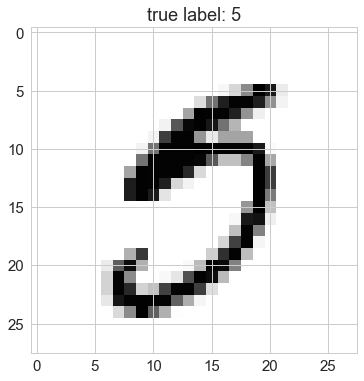

In [40]:
plot_digit(X_test, y_test, idx=70)

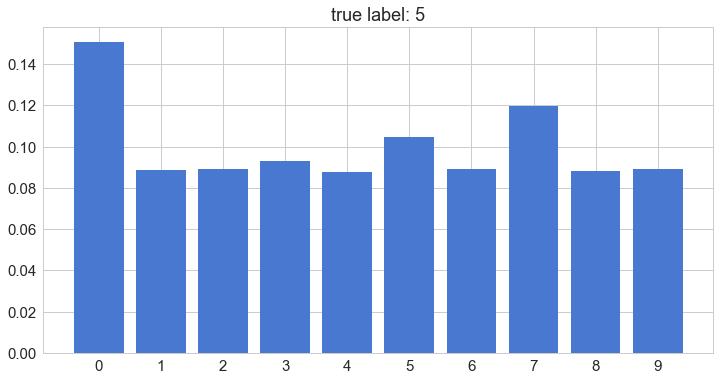

In [41]:
plot_digit_dist(X_test, y_test, idx=70, model=nn)

Come on, look at that picture. How is that a 5? 

### MLE = picking the most probable digit

Ok, but how does the prediction work? Simply put, it uses the most probable value in the class distribution:

In [30]:
mle(nn.predict_proba(X_test[:5]))

array([1, 6, 1, 0, 5])

In [31]:
nn.predict(X_test[:5])

array([1, 6, 1, 0, 5])

# Trying a bit harder

The performance of our model was not that great. Can we improve on that?

Let's try to scale our input data:

In [98]:
from sklearn.preprocessing import scale, normalize

X_train_std = scale(X_train.astype(np.float64))
X_test_std = scale(X_test.astype(np.float64))

nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train_std, y_train);

print('Test Accuracy: %.2f%%' % (nn.score(X_test_std, y_test) * 100))

Test Accuracy: 84.80%


Not bad, about 3% increase using simple preprocessing. What if we fiddle with the parameters a bit:

In [42]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=250,
                  l2=0.5,
                  l1=0.0,
                  epochs=500,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train, y_train);

print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Test Accuracy: 86.77%


Another 2% increase. Now, we're in the "acceptable" range. Will the combination of the two approaches yield an even better result? Why don't you try it out?

# Conclusion

What a journey, right? We've learned a lot about the inner workings of the Neural Network models. More importantly, we've implemented the backpropagation algorithm - twice! Hopefully, you got some practical understanding of the processes involved in training a Neural Network. Can you adapt the code and make a Deep Neural Network?

# References

- [Biases in NNs?](https://stackoverflow.com/questions/2480650/role-of-bias-in-neural-networks)<br/>
- [L1 and L2 Regularization](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)<br/>
- [Learn how to do backprop from the pros](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)<br/>
- [Backpropagation, Intuitions](https://cs231n.github.io/optimization-2/)